# Correcting absolute hydration free energies using support vector machines

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Global-variables" data-toc-modified-id="Global-variables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Global variables</a></span><ul class="toc-item"><li><span><a href="#Model-parameters" data-toc-modified-id="Model-parameters-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Model parameters</a></span></li><li><span><a href="#Matplotlib-parameters" data-toc-modified-id="Matplotlib-parameters-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Matplotlib parameters</a></span></li></ul></li><li><span><a href="#Path-variables" data-toc-modified-id="Path-variables-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Path variables</a></span></li><li><span><a href="#Logger" data-toc-modified-id="Logger-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Logger</a></span></li><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Data preparation</a></span><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Cross-validation" data-toc-modified-id="Cross-validation-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Cross validation</a></span></li></ul></li><li><span><a href="#Training" data-toc-modified-id="Training-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Training</a></span><ul class="toc-item"><li><span><a href="#Hyper-parameter-ranges" data-toc-modified-id="Hyper-parameter-ranges-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Hyper-parameter ranges</a></span></li><li><span><a href="#SVR-model" data-toc-modified-id="SVR-model-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>SVR model</a></span></li><li><span><a href="#Training-function" data-toc-modified-id="Training-function-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Training function</a></span></li><li><span><a href="#Perform-training-per-fold" data-toc-modified-id="Perform-training-per-fold-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Perform training per fold</a></span></li><li><span><a href="#Convergence-plot" data-toc-modified-id="Convergence-plot-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>Convergence plot</a></span></li></ul></li><li><span><a href="#Popagation-of-errors" data-toc-modified-id="Popagation-of-errors-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Popagation of errors</a></span><ul class="toc-item"><li><span><a href="#Average-error" data-toc-modified-id="Average-error-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Average error</a></span></li><li><span><a href="#Root-mean-square-error" data-toc-modified-id="Root-mean-square-error-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Root mean square error</a></span></li><li><span><a href="#Kendall-$\tau$" data-toc-modified-id="Kendall-$\tau$-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Kendall $\tau$</a></span></li><li><span><a href="#Pearson-R" data-toc-modified-id="Pearson-R-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Pearson R</a></span></li><li><span><a href="#Mean-absolute-error" data-toc-modified-id="Mean-absolute-error-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>Mean absolute error</a></span></li><li><span><a href="#Linear-combination" data-toc-modified-id="Linear-combination-7.6"><span class="toc-item-num">7.6&nbsp;&nbsp;</span>Linear combination</a></span></li></ul></li><li><span><a href="#External-testing" data-toc-modified-id="External-testing-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>External testing</a></span><ul class="toc-item"><li><span><a href="#Load-testing-data" data-toc-modified-id="Load-testing-data-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Load testing data</a></span></li><li><span><a href="#Original-$\Delta-G_{hydr}$" data-toc-modified-id="Original-$\Delta-G_{hydr}$-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Original $\Delta G_{hydr}$</a></span></li><li><span><a href="#$\Delta-G_{offset}$-prediction" data-toc-modified-id="$\Delta-G_{offset}$-prediction-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>$\Delta G_{offset}$ prediction</a></span></li><li><span><a href="#$\Delta-G_{hydr}$-correction" data-toc-modified-id="$\Delta-G_{hydr}$-correction-8.4"><span class="toc-item-num">8.4&nbsp;&nbsp;</span>$\Delta G_{hydr}$ correction</a></span></li></ul></li><li><span><a href="#Control" data-toc-modified-id="Control-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Control</a></span></li><li><span><a href="#Removing-outlier" data-toc-modified-id="Removing-outlier-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Removing outlier</a></span></li><li><span><a href="#Recreating-SAMPL4-Figure-1" data-toc-modified-id="Recreating-SAMPL4-Figure-1-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Recreating SAMPL4 Figure 1</a></span></li></ul></div>

## Imports

In [1]:
# General:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter
import os
import csv
import time
import shutil
import logging
import pickle
import statistics
from tqdm import tqdm_notebook as tqdm

# SVM:
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# SciKit-Optimise:
from skopt import gp_minimize, dump
from skopt.space import Categorical
from skopt.utils import use_named_args

# Statistics:
import scipy
from numpy.polynomial.polynomial import polyfit
from uncertainties import unumpy
import itertools
itertools.imap = lambda *args, **kwargs: list(map(*args, **kwargs))

/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Global variables

### Model parameters

In [2]:
# Global variables:
model_type = 'SVM'
kernel = 'rbf'
label_col = 'dGoffset (kcal/mol)'
null_label_col = 'Experimental dGhydr (kcal/mol)'

# Set data processing configurations:
n_calls = 40  # Number of Bayesian optimisation loops for hyper-parameter optimisation, 40 is best for convergence, > 60 scales to very expensive
best_mae = np.inf  # Point to consider top-performing model from (MAE/MAD); 1.0 = no improvement on test-set variance

# KFold parameters:
n_splits = 5  # Number of K-fold splits
random_state = 2  # Random number seed

### Matplotlib parameters

In [3]:
figsize = [7, 7]
fontsize = 18
markersize = 20
linewidth = 2
dGhydr_xylim = [-25.0, 5.0]
dGoffset_xylim = [-4.0, 4.0]
colour1 = 'darkgray'
colour2 = 'green'
colour3 = 'lightsteelblue'
colour4 = 'palegreen'
dpi = 300

## Path variables

In [4]:
# Path variables:
datasets_dr = '../datasets/'
SDF_dr = datasets_dr + 'sdffiles/'
freesolv_loc = datasets_dr + 'freesolv_database.txt'

# clean slate output_dr
output_dr = 'output/'
if os.path.exists(output_dr):
    shutil.rmtree(output_dr)
if not os.path.exists(output_dr):
    os.mkdir(output_dr)

# clean slate figures_dr
figures_dr = 'figures/'
if os.path.exists(figures_dr):
    shutil.rmtree(figures_dr)
if not os.path.exists(figures_dr):
    os.mkdir(figures_dr)

## Logger

In [5]:
# initiate log file
logging.basicConfig(filename= output_dr + 'dGhydr_' + model_type + '.log',
                    filemode='a',
                    format='%(asctime)s - %(message)s',
                    level=logging.INFO)

logging.info('Starting {}.ipynb.'.format(os.path.abspath('')))
logging.info('\n\nParameters:\n\nn_calls = {}  # gp_minimize\nn_splits = {}  # Kfolds\n'.format(n_calls, n_splits))

## Data preparation

### Load data

In [6]:
train_path = datasets_dr + 'train_data.csv'
train_df = pd.read_csv(train_path, index_col='ID').iloc[:,:-1]
logging.info('Loaded training data from {} removing dGoffset uncertainties column.'.format(train_path))
train_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,dGoffset (kcal/mol)
ID,,,,,,,,,,,,,,,,,,,,,
mobley_1017962,1.781592,-9.059647,3.780119,-1.056808,-1.528974,1.154161,2.361153,-2.700138,-5.169281,-2.558583,...,0.176910,0.448660,-0.481919,-0.730970,1.433422,-0.871800,-0.046023,0.146078,-0.985729,0.81
mobley_1019269,-15.261008,-4.347183,1.379246,0.645708,1.531135,0.856268,2.825631,1.283684,-3.142267,-1.366230,...,0.650525,-0.065040,-0.539433,0.367840,0.331124,0.003756,-0.432505,-0.340372,0.021577,-1.49
mobley_1034539,36.296153,18.307947,-16.146556,9.478137,5.356792,-1.551679,8.356573,-6.716154,-1.947512,7.365367,...,0.168824,0.777216,1.135480,0.712777,-0.498693,0.691487,-1.452439,0.096043,-1.621214,-1.96
mobley_1036761,-7.287637,-6.559314,-4.371576,-0.002275,1.794860,5.108000,0.532538,-1.465378,-2.029966,-1.791384,...,0.644729,0.141384,2.021007,0.251282,-0.186177,0.216360,-2.022736,-0.802692,-0.227339,-0.64
mobley_1046331,0.013096,5.160060,-0.553108,-8.828100,-1.271934,-2.744112,1.456818,0.573025,-3.004421,-1.923495,...,-0.823191,0.277780,1.177761,-0.455553,0.149812,-0.992073,-0.448685,-0.195229,0.616093,1.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mobley_9913368,-20.236474,9.027594,-0.488696,6.984286,2.903779,-4.453868,1.557532,1.482581,-0.569213,-0.728069,...,0.662516,0.124512,-1.252097,0.093136,0.964358,1.117784,-0.596488,0.125104,-0.104126,-1.80
mobley_9942801,0.465744,-3.377600,-9.321441,-5.431455,0.795493,0.275491,-3.901344,-1.813911,3.214033,0.992900,...,0.550031,-0.060056,0.567654,0.528096,0.281406,-0.258472,0.607825,0.480860,-0.378041,-0.38
mobley_994483,-23.790773,3.251655,-1.631419,11.152238,3.508680,-7.857823,-2.714649,3.183763,0.001303,-1.865963,...,0.202422,-0.385468,0.059621,-1.176402,0.542244,0.026653,-1.198516,-0.103893,0.185989,-1.23


### Cross validation

In [7]:
def split_dataset(dataset, n_splits, random_state, label_name):
    """KFold implementation for pandas DataFrame.
    (https://stackoverflow.com/questions/45115964/separate-pandas-dataframe-using-sklearns-kfold)"""
    logging.info('Performing {}-fold cross-validation...'.format(n_splits))

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    kfolds = []
    global offset_col_name

    for train, validate in kf.split(dataset):
        training = dataset.iloc[train]
        train_labels = training[label_name]
        train_set = training.drop(label_name, axis=1)

        validating = dataset.iloc[validate]
        validate_labels = validating[label_name]
        validate_set = validating.drop(label_name, axis=1)

        kfolds.append(
            [[train_set, validate_set],
             [train_labels, validate_labels]]
        )

    json_path = output_dr +'kfolds.json'
    with open(json_path, "wb") as file:
        pickle.dump(kfolds, file)

    logging.info('Pickled kfolds nested list at {}.'.format(json_path))
    return kfolds

In [8]:
# Call function
kfolds = split_dataset(train_df, n_splits, random_state, label_col)

## Training

### Hyper-parameter ranges

In [9]:
# Set hyper-parameter ranges and append to list.
dim_param_C = Categorical(categories=list(np.logspace(-3, 2, 6, dtype="float32")), name="param_C")
dim_param_gamma = Categorical(categories=list(np.logspace(-3, 2, 6, dtype="float32")), name="param_gamma")
dim_param_epsilon = Categorical(categories=list(np.logspace(-3, 2, 6, dtype="float32")), name="param_epsilon")

# gp_minimize dimensions
dimensions = [dim_param_C, dim_param_gamma, dim_param_epsilon]

### SVR model

In [10]:
def create_model(param_gamma, param_C, param_epsilon):
    """Returns a SVR class instance."""
    
    return SVR(kernel=kernel,
               gamma=param_gamma,
               C=param_C,
               epsilon=param_epsilon,
               verbose=False)

### Training function

In [11]:
# Init. training statistics logger.
mae_logger = output_dr + model_type + '_mae_per_call.csv'
with open(mae_logger, 'w') as file:
    writer = csv.writer(file)
    writer.writerow(['Fold', 'MAE (kcal/mol)', 'Parameters'])

In [12]:
class tqdm_skopt(object):
    """tqdm implementation for skopt.gp_minimize."""
    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)
        
    def __call__(self, res):
        self._bar.update()

In [13]:
def train_model(fold, fold_num, *args):
    """
    1. Unpack data.
    2. Define fitness function for guassian process optmisation.
    3. Decorate fitness with pre-defined hyper-parameter ranges.
    4. Return and pickle final gp_minimize object.
    """
    logging.info('Started training fold {}...'.format(str(fold_num)))

    # Retrieve data sets and convert to numpy array
    train_X = fold[0][0].values
    validate_X = fold[0][1].values
    train_y = fold[1][0].values
    validate_y = fold[1][1].values
    
    # Specify whether model is null.
    null = ''
    for arg in args:
        null = arg + '_'
    
    # Define function for gaussian process optimisation
    @use_named_args(dimensions=dimensions)
    def fitness(param_C, param_gamma, param_epsilon):
        """Function for gaussian process optmisation."""

        # Create SVR model
        model = create_model(param_C, param_gamma, param_epsilon)

        # Train model on training data
        model.fit(train_X, train_y)

        # Validate model
        predicted_y = model.predict(validate_X)
        mae = mean_absolute_error(validate_y, predicted_y)

        # Update statistics
        with open(mae_logger, 'a') as file:
            writer = csv.writer(file)
            writer.writerow([fold_num, mae, [param_gamma, param_gamma, param_epsilon]])

        # Check if model improves
        global best_mae
        if mae < best_mae:
            # Update new model accuracy.
            best_mae = mae
            # Overwrite model if mae improves
            pkl_file = output_dr + 'fold_' + str(fold_num) + '_' + null + model_type + '_model.pickle'
            with open(pkl_file, 'wb') as file: pickle.dump(model, file)
            logging.info('Saved {}.'.format(pkl_file))

        # # Reset best MAE
        # best_mae = np.inf
        
        return mae
    
    # Starting parameters
    default_parameters = [1.0, 1.0, 1.0]
    # Optimise hyper-parameters
    search_result = gp_minimize(func=fitness,
                                dimensions=dimensions,
                                acq_func='EI',  # Expected Improvement.
                                n_calls=n_calls,
                                x0=default_parameters,
                                verbose=False,
                                callback=[tqdm_skopt(total=n_calls, desc='Fold {}'.format(fold_num))])

    # Save skopt object and analyse in a separate script as
    logging.info('Saved {}fold_{}_gp_minimize_result.pickle.'.format(output_dr, fold_num))

    logging.info('Finished training fold {}: {}.'.format(str(fold_num), search_result.x))
    return search_result

### Perform training per fold

In [14]:
# # Call train_model and save gp_minimize objects to list.
# gp_results = [train_model(fold, fold_num + 1) for fold_num, fold in enumerate(kfolds)]
gp_results = []
for fold_num, fold in enumerate(kfolds):
    gp_results.append(train_model(fold, fold_num + 1))
    best_mae = np.inf  # Reset best MAE

/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


### Convergence plot

In [15]:
def mae_convergence(dataframe):

    # x values
    x = np.linspace(1, 40, 40)

    # y values
    mae = [dataframe.loc[dataframe.iloc[:, 0] == fold, 'MAE (kcal/mol)'].cummin()
           for fold in range(1, n_splits + 1)]
    cumm_mae = list(zip(*mae))
    y = [statistics.mean(call) for call in cumm_mae]

    # standard devation
    std = [statistics.stdev(call) for call in cumm_mae]

    # standard devation bounds
    y1 = [i - sd for i, sd in zip(y, std)]
    y2 = [i + sd for i, sd in zip(y, std)]

    # plot mean line
    fig, ax = plt.subplots(figsize=figsize)
    for axis in ['top','bottom','left','right']: ax.spines[axis].set_linewidth(linewidth)

    ax.plot(x, y,
            color=colour2,
            linewidth=linewidth,
            label='Average MAE over {} folds'.format(n_splits))

    # plot standard deviation fill bounds
    ax.fill_between(x, y1, y2,
                    fc=colour3,
                    ec=colour3,
                    label='Standard deviation')

    ax.set_xlabel('Number of calls $n$', fontsize=fontsize)
    ax.set_ylabel('MAE / kcal mol$^{-1}$', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

    ax.legend(fontsize=fontsize)
    plt.tight_layout()
    
    fig.savefig(figures_dr + 'convergence_plot.png', dpi=dpi)
    
    return ax

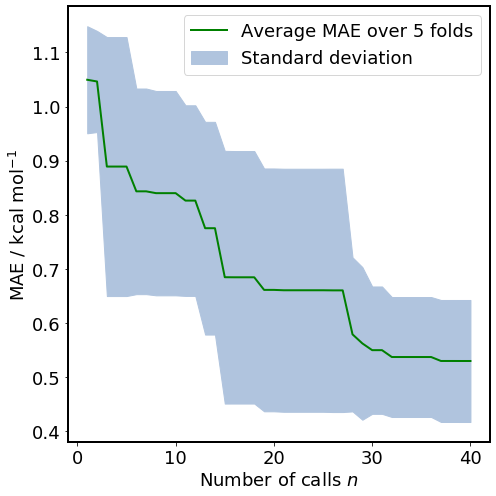

In [16]:
mae_logger = output_dr + model_type + '_mae_per_call.csv'
mae_df = pd.read_csv(mae_logger)  # Load previously defined training statistics logger.
mae_convergence(mae_df)  # Plot convergence plot.

## Popagation of errors

### Average error

In [17]:
def avg_err(x, y):
    """Returns an averaged error between two lists.
    Assumes len(x) == len(y)."""
    err = [i - j for i, j in zip(x, y)]
    return sum(err) / len(err)

### Root mean square error

$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^n (x_{i} - y_{i})^{2}}
$

In [18]:
def rmse(x, y):
    """Returns the root means squared error of two lists.
    Assumes len(x) == len(y)"""
    num = sum([(i - j)**2 for i, j in zip(x, y)])
    den = len(x)
    return (num / den)**0.5

### Kendall $\tau$

In [19]:
def kendall_tau(x, y):
    tau, p_value = scipy.stats.kendalltau(x, y)
    return tau

### Pearson R


$
  r =
  \frac{ \sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y}) }{%
        \sqrt{\sum_{i=1}^{n}(x_i-\bar{x})^2}\sqrt{\sum_{i=1}^{n}(y_i-\bar{y})^2}}
$

In [20]:
def calc_pearson_r(x, y):
    """
    Calculates Pearson R value.
    Assumes len(x) == len(y).
    Parameters
    ----------
    x: array like of uncertainties.core.Variable
    y: array like of uncertainties.core.Variable
    ----------
    Returns array like of uncertainties.core.Variable
    """
    n = len(x)  # number of samples
    try:
        x_norm = [i.n for i in x]  # x without uncertainty
        y_norm = [i.n for i in y]  # y without uncertainty
    except AttributeError:
        x_norm = x
        y_norm = y
    sum_x = float(sum(x_norm))  # sum of x
    sum_y = float(sum(y_norm))  # sum of y
    sum_x_sq = sum(itertools.imap(lambda x: pow(x, 2), x))  # sum of x**2
    sum_y_sq = sum(itertools.imap(lambda x: pow(x, 2), y))  # sum of y**2
    psum = sum(itertools.imap(lambda x, y: x * y, x, y))  # sum of x*y
    num = psum - (sum_x * sum_y/n)  # Pearson R equation numerator
    den = pow((sum_x_sq - pow(sum_x, 2) / n) * (sum_y_sq - pow(sum_y, 2) / n), 0.5)  # Pearson R formular demoninator
    if den == 0: return 0  # Prevent division by zero
    return num / den

### Mean absolute error


$
<insert \: formula>
$

In [21]:
def calc_mae(x, y):
    """Returns list of mean absolute error between two lists.
    Assumes len(x) == len(y)."""
    ae = [abs(i - j) for i, j in zip(x, y)]
    return sum(ae) / len(ae)

### Linear combination

In [22]:
def sum_error(error1, error2):
    """Returns sum propagated error between two int or floats."""
    return (error1 ** 2 + error2 ** 2) ** 0.5

## External testing

In [23]:
from sklearn.linear_model import LinearRegression

In [24]:
def plot_scatter(calc, exp, title, x_label, y_label, colour):
    """
    Returns and saves linear regression scatter plot.
    Note: takes pre-defined global variables: figsize, linewidth, fontsize, dGhydr_xlim, dGhydr_ylim, markersize, colour1 and colour2,
    and pre-defined functions: calc_mae() and calc_pearson_r().
    Parameters
    ----------
    calc: (DataFrame) calculated data at column index 0 with associated errors at column index 1.
    exp: (DataFrame) experimental data at column index 0 with associated errors at column index 1.
    title: (str) plot title and filename delimitted by underscores. Avoid special characters.
    x_label: (str) x-axis label.
    y_label: (str) y-axis label.
    """
    
    # Unpack data.
    x = calc.iloc[:,0]
    y = exp.iloc[:,0]
    
    # Setup figure.
    fig, ax = plt.subplots(figsize=figsize)
    for axis in ['top','bottom','left','right']: ax.spines[axis].set_linewidth(linewidth)  # Frame line width.
    ax.tick_params(axis='both', which='major', direction='out', length=7, width=linewidth,
                   labelsize=fontsize, top=True, right=True, bottom=True, left=True)
    ax.set_xlabel(x_label, fontsize=fontsize)  # X-axis label font size.
    ax.set_ylabel(y_label, fontsize=fontsize)  # Y-axis label font size.
    if 'offset' in title:
        ax.set_xlim(dGoffset_xylim)  # x-axis range.
        ax.set_ylim(dGoffset_xylim)  # y-axis range.
    else:
        ax.set_xlim(dGhydr_xylim)  # x-axis range.
        ax.set_ylim(dGhydr_xylim)  # y-axis range.
    
    # Plot scatter.
    ax.scatter(x, y, color=colour, s=markersize)

    # Plot x = y line.
    xlin = np.linspace(-100, 100, 200)  # linear x
    ylin = np.linspace(-100, 100, 200)  # linear y
    ax.plot(xlin, ylin, color='k', linewidth=linewidth, linestyle='--')
    
#     # Uncomment to overplot line of best fit.
#     ax.plot(np.unique(x),
#             np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),
#             color='k', linewidth=linewidth, linestyle='-',
#             scalex=False, scaley=False)
    
    # Create uncertainties.core.Variable for statistical analysis
    xu = unumpy.uarray(calc.iloc[:,0], calc.iloc[:,1])
    yu = unumpy.uarray(exp.iloc[:,0], exp.iloc[:,1])
    
    # Calculate mean absolute error.
    mae = calc_mae(xu, yu)
    
    # Calculate Pearson R.
    r_value = calc_pearson_r(xu, yu)

    # Annotate with mean absolute error and Pearson R.
    string = 'MAE = {} {}\nR = {}'.format(mae, 'kcal mol$^{-1}$', r_value).replace('+/-', ' $\pm$ ')
    ax.annotate(string, xy=(0, 1), xytext=(12, -12), va='top',
                 xycoords='axes fraction', textcoords='offset points',
                 size=fontsize)
    
    # Save figure using the title as filename.
    filename = figures_dr + str(title).lower().replace(' ', '_') + '.png'
    plt.savefig(filename, dpi=dpi)
    logging.info('Saved {}.'.format(filename))

### Load testing data

All data is read and spliced as DataFrames sorted by index.

FreeSolv database

In [25]:
freesolv_df = pd.read_csv(freesolv_loc, sep='; ', engine='python').rename(columns={'compound id (and file prefix)': 'ID'})
freesolv_df = freesolv_df.set_index('ID').sort_index()

Experimental $\Delta G_{hydr}$ values with respective uncertainties.

In [26]:
test_exp = freesolv_df.loc[freesolv_df.iloc[:, 6] == 'SAMPL4_Guthrie',
                           ['experimental value (kcal/mol)', 'experimental uncertainty (kcal/mol)']].sort_index()

FEP-calculated $\Delta G_{hydr}$ values with respective uncertainties.

In [27]:
test_fep = freesolv_df.loc[freesolv_df.iloc[:, 6] == 'SAMPL4_Guthrie',
                           ['Mobley group calculated value (GAFF) (kcal/mol)', 'calculated uncertainty (kcal/mol)']].sort_index()

Test set features.

In [28]:
test_X = pd.read_csv(datasets_dr + 'test_data.csv', index_col='ID').iloc[:,:-2].sort_index()

Test set labels with respetive uncertainties.

In [29]:
test_y = pd.read_csv(datasets_dr + 'test_data.csv', index_col='ID').iloc[:,-2:].sort_index()

Correct index order to compare against later.

In [30]:
test_ID = test_y.index

### Original $\Delta G_{hydr}$

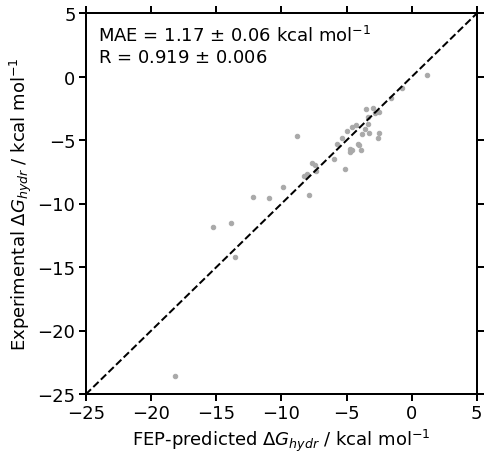

In [31]:
plot_scatter(calc=test_fep,
             exp=test_exp,
             title='Original test set hydraton free energy',
             x_label='FEP-predicted $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             colour=colour1)

### $\Delta G_{offset}$ prediction

In [32]:
def model_predict(model_num, test_entry, *args):
    """Load model from pickle and return model prediction on a given test_entry."""

    null = ''
    for arg in args:
        null = arg + '_'
    
    with open(output_dr + 'fold_' + str(model_num) + '_' + null + model_type + '_model.pickle', 'rb') as f:
        model = pickle.load(f)

    return model.predict(test_entry)

Predict offset per fold.

In [33]:
predict_per_fold = [model_predict(fold_num, test_X.to_numpy()) for fold_num in range(1, n_splits + 1)]

Average predicted offset over all folds and calculate the standard deviation.

In [34]:
predicted_y = pd.DataFrame(data={'Average predicted dGoffset (kcal/mol)': [float(x) for x in np.average(predict_per_fold, axis=0)],
                                 'Standard deviation (kcal/mol)': np.std(predict_per_fold, axis=0)},
                           index=test_ID)

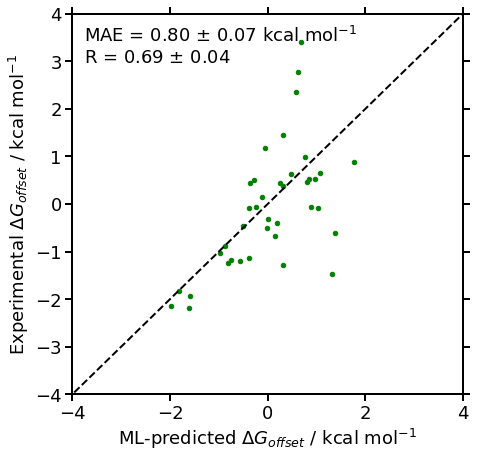

In [35]:
plot_scatter(calc=predicted_y,
             exp=test_y,
             title='SVM-predicted test set offsets',
             x_label='ML-predicted $\Delta G_{offset}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta G_{offset}$ / kcal mol$^{-1}$',
             colour=colour2)

### $\Delta G_{hydr}$ correction

Since,
$\Delta G_{offset} = \Delta G_{exp} - \Delta G_{FEP}$

$\therefore \Delta G_{corrected} = \Delta G_{FEP} + \Delta G_{offset}$

In [36]:
test_corr = pd.DataFrame(data={'FEP+ML dGoffset (kcal/mol)': [fep + offset for fep, offset in zip(test_fep.iloc[:,0], predicted_y.iloc[:,0])],
                               'uncertainty (kcal/mol)': [sum_error(x, y) for x, y in zip(predicted_y.iloc[:,1], test_fep.iloc[:,1])]},
                         index=test_ID)

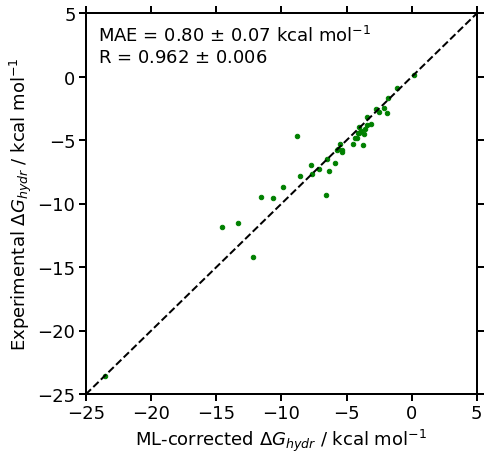

In [37]:
plot_scatter(calc=test_corr,
             exp=test_exp,
             title='FEP+ML corrected test set hydraton free energy',
             x_label='ML-corrected $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             colour=colour2)

In [38]:
def plot_scatter_with_arrows(calc, exp, offsets, corr):
    """
    Returns and saves several overlayed plots:
    1. Uncorrected scatter plot between calculated and experiemntal values.
    2. Corrected scatter plot between corrections and experiemntal values.
    3. Line of best fit for the aforementioned corrected scatter plot.
    4. Arrows in the form of annotations between respective uncorrected and corrected scatter points.
    Note: takes pre-defined global variables: linewidth, fontsize, dGhydr_xlim, dGhydr_ylim, markersize, colour1 and colour2,
    and pre-defined functions: calc_mae() and calc_pearson_r().
    ----------
    Parameters
    ----------
    calc: (DataFrame) calculated data at column index 0 with associated errors at column index 1.
    exp: (DataFrame) experimental data at column index 0 with associated errors at column index 1.
    offsets: (DataFrame) predicted offsets at column index 0 with associated errors at column index 1.
    corr: (DataFrame) corrected calculated data at column index 0 with associated errors at column index 1.
    """
    
    # Unpack data.
    x_fep = calc.iloc[:,0]
    x_ml = corr.iloc[:,0]
    y = exp.iloc[:,0]
    offset = offsets.iloc[:,0]
    
    # Setup figure.
    fig, ax = plt.subplots(figsize=figsize)
    for axis in ['top','bottom','left','right']: ax.spines[axis].set_linewidth(linewidth)
    ax.tick_params(axis='both', which='major', direction='out', length=7, width=linewidth,
                   labelsize=fontsize, top=True, right=True, bottom=True, left=True)
    ax.set_xlabel('Predicted $\Delta G_{hydr}$ / kcal mol$^{-1}$', fontsize=fontsize)
    ax.set_ylabel('Experimental $\Delta G_{hydr}$ / kcal mol$^{-1}$', fontsize=fontsize)
    ax.set_xlim(dGhydr_xylim)
    ax.set_ylim(dGhydr_xylim)
    
    # Plot FEP vs exp and FEP+ML vs exp.
    ax.scatter(x_fep, y, color=colour1, s=markersize, label='FEP')
    ax.scatter(x_ml, y, color=colour2, s=markersize, label='FEP+ML')
    
    # Plot x = y line.
    xlin = np.linspace(-100, 100, 200)  # linear x
    ylin = np.linspace(-100, 100, 200)  # linear y
    ax.plot(xlin, ylin, color='k', linewidth=linewidth)
    
    # # Uncomment to plot line of best fit.
    # ax.plot(np.unique(x_ml),
    #     np.poly1d(np.polyfit(x_ml, y, 1))(np.unique(x_ml)),
    #      color='black', linewidth=linewidth)
    
    # Annotate with arrows.
    for o, f, e in zip(offset, x_fep, y):
        fep_corrected = f + o
        fep_offset = e - f
        fep_corrected_offset = e - fep_corrected
        
        if abs(fep_corrected_offset) <= abs(fep_offset):
            line_color = "green"
        else:
            line_color = "red"
            
        ax.annotate("", xytext=(f, e), xy=(fep_corrected, e), 
                     arrowprops=dict(arrowstyle="->", color=line_color))

    # create uncertainties.core.Variable for statistical analysis
    xu = unumpy.uarray(corr.iloc[:,0], corr.iloc[:,1])
    yu = unumpy.uarray(exp.iloc[:,0], exp.iloc[:,1])
    
    # mean absolute error
    mae = calc_mae(xu, yu)
    
    # Pearson R and R-squared
    r_value = calc_pearson_r(xu, yu)

    # annotate with r-squared and MAE
    string1 = 'MAE = 1.17 {} 0.06 {}\nR = 0.919 {} 0.006'.format('$\pm$', 'kcal mol$^{-1}$', '$\pm$')
    string2 = 'MAE = {} {}\nR = {}'.format(mae, 'kcal mol$^{-1}$', r_value).replace('+/-', ' $\pm$ ')
    ax.annotate(string1, xy=(0, 1), xytext=(12, -12), va='top',
             xycoords='axes fraction', textcoords='offset points',
             size=fontsize, color=colour1)
    ax.annotate(string2, xy=(0, 0.88), xytext=(12, -12), va='top',
             xycoords='axes fraction', textcoords='offset points',
             size=fontsize, color=colour2)

    # Create legend.
    plt.legend(loc='lower right', fontsize=fontsize, frameon=False, handletextpad=0.1)
    
    plt.gcf().subplots_adjust(left=0.15)
    
    # Save figure.
    filename = figures_dr + 'offset_mapping.png'
    plt.savefig(filename, dpi=dpi)
    logging.info('Saved {}.'.format(filename))

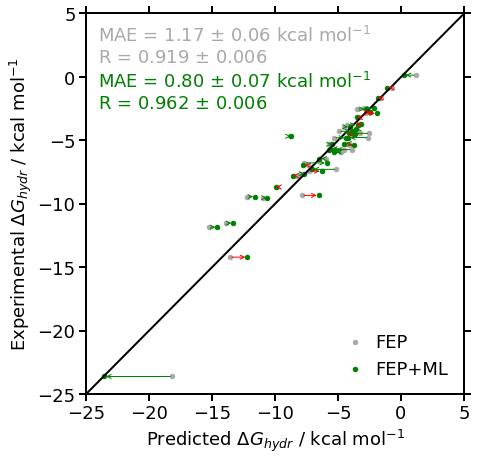

In [39]:
plot_scatter_with_arrows(calc=test_fep,
                         exp=test_exp,
                         offsets=predicted_y,
                         corr=test_corr)

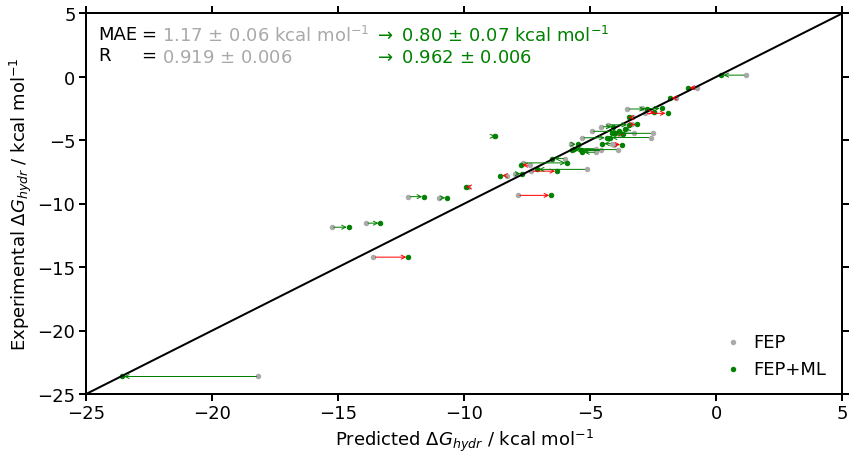

In [40]:
def plot_scatter_with_arrows_2(calc, exp, offsets, corr):
    """
    Returns and saves several overlayed plots:
    1. Uncorrected scatter plot between calculated and experiemntal values.
    2. Corrected scatter plot between corrections and experiemntal values.
    3. Line of best fit for the aforementioned corrected scatter plot.
    4. Arrows in the form of annotations between respective uncorrected and corrected scatter points.
    Note: takes pre-defined global variables: linewidth, fontsize, dGhydr_xlim, dGhydr_ylim, markersize, colour1 and colour2,
    and pre-defined functions: calc_mae() and calc_pearson_r().
    ----------
    Parameters
    ----------
    calc: (DataFrame) calculated data at column index 0 with associated errors at column index 1.
    exp: (DataFrame) experimental data at column index 0 with associated errors at column index 1.
    offsets: (DataFrame) predicted offsets at column index 0 with associated errors at column index 1.
    corr: (DataFrame) corrected calculated data at column index 0 with associated errors at column index 1.
    """
    
    # Unpack data.
    x_fep = calc.iloc[:,0]
    x_ml = corr.iloc[:,0]
    y = exp.iloc[:,0]
    offset = offsets.iloc[:,0]
    
    # Setup figure.
    fig, ax = plt.subplots(figsize=[14,7])
    for axis in ['top','bottom','left','right']: ax.spines[axis].set_linewidth(linewidth)
    ax.tick_params(axis='both', which='major', direction='out', length=7, width=linewidth,
                   labelsize=fontsize, top=True, right=True, bottom=True, left=True)
    ax.set_xlabel('Predicted $\Delta G_{hydr}$ / kcal mol$^{-1}$', fontsize=fontsize)
    ax.set_ylabel('Experimental $\Delta G_{hydr}$ / kcal mol$^{-1}$', fontsize=fontsize)
    ax.set_xlim(dGhydr_xylim)
    ax.set_ylim(dGhydr_xylim)
    
    # Plot FEP vs exp and FEP+ML vs exp.
    ax.scatter(x_fep, y, color=colour1, s=markersize, label='FEP')
    ax.scatter(x_ml, y, color=colour2, s=markersize, label='FEP+ML')
    
    # Plot x = y line.
    xlin = np.linspace(-100, 100, 200)  # linear x
    ylin = np.linspace(-100, 100, 200)  # linear y
    ax.plot(xlin, ylin, color='k', linewidth=linewidth)
    
    # # Uncomment to plot line of best fit.
    # ax.plot(np.unique(x_ml),
    #     np.poly1d(np.polyfit(x_ml, y, 1))(np.unique(x_ml)),
    #      color='black', linewidth=linewidth)
    
    # Annotate with arrows.
    for o, f, e in zip(offset, x_fep, y):
        fep_corrected = f + o
        fep_offset = e - f
        fep_corrected_offset = e - fep_corrected
        
        if abs(fep_corrected_offset) <= abs(fep_offset):
            line_color = "green"
        else:
            line_color = "red"
            
        ax.annotate("", xytext=(f, e), xy=(fep_corrected, e), 
                     arrowprops=dict(arrowstyle="->", color=line_color))

    # create uncertainties.core.Variable for statistical analysis
    xu = unumpy.uarray(corr.iloc[:,0], corr.iloc[:,1])
    yu = unumpy.uarray(exp.iloc[:,0], exp.iloc[:,1])
    
    # mean absolute error
    mae = calc_mae(xu, yu)
    
    # Pearson R and R-squared
    r_value = calc_pearson_r(xu, yu)

    # annotate with r-squared and MAE
    string1 = 'MAE\nR'
    string2 = '=\n='
    string3 = '1.17 {} 0.06 {}\n0.919 {} 0.006'.format('$\pm$', 'kcal mol$^{-1}$', '$\pm$')
    string4 = '{} {} {}\n{} {}'.format(r'$\rightarrow$', mae, 'kcal mol$^{-1}$', r'$\rightarrow$', r_value).replace('+/-', ' $\pm$ ')
    ax.annotate(string1, xy=(0.0, 1), xytext=(12, -12), va='top',
             xycoords='axes fraction', textcoords='offset points',
             size=fontsize, color='k')
    ax.annotate(string2, xy=(0.0565, 1), xytext=(12, -12), va='top',
             xycoords='axes fraction', textcoords='offset points',
             size=fontsize, color='k')
    ax.annotate(string3, xy=(0.085, 1), xytext=(12, -12), va='top',
         xycoords='axes fraction', textcoords='offset points',
         size=fontsize, color=colour1)
    ax.annotate(string4, xy=(0.365, 1), xytext=(12, -12), va='top',
         xycoords='axes fraction', textcoords='offset points',
         size=fontsize, color=colour2)

    # Create legend.
    plt.legend(loc='lower right', fontsize=fontsize, frameon=False, handletextpad=0.1)
    
    plt.gcf().subplots_adjust(left=0.15)
    
    # Save figure.
    filename = figures_dr + 'offset_mapping_2.png'
    plt.savefig(filename, dpi=dpi)
    logging.info('Saved {}.'.format(filename))


plot_scatter_with_arrows_2(calc=test_fep,
                           exp=test_exp,
                           offsets=predicted_y,
                           corr=test_corr)

## Control

In [41]:
null_train_path = datasets_dr + 'null_train_data.csv'
null_train_df = pd.read_csv(null_train_path, index_col='ID').iloc[:,:-1]
logging.info('Loaded training data from {} removing dGoffset uncertainties column.'.format(null_train_path))
null_train_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,Experimental dGhydr (kcal/mol)
ID,,,,,,,,,,,,,,,,,,,,,
mobley_1017962,1.781592,-9.059647,3.780119,-1.056808,-1.528974,1.154161,2.361153,-2.700138,-5.169281,-2.558583,...,0.176910,0.448660,-0.481919,-0.730970,1.433422,-0.871800,-0.046023,0.146078,-0.985729,-2.49
mobley_1019269,-15.261008,-4.347183,1.379246,0.645708,1.531135,0.856268,2.825631,1.283684,-3.142267,-1.366230,...,0.650525,-0.065040,-0.539433,0.367840,0.331124,0.003756,-0.432505,-0.340372,0.021577,-4.72
mobley_1034539,36.296153,18.307947,-16.146556,9.478137,5.356792,-1.551679,8.356573,-6.716154,-1.947512,7.365367,...,0.168824,0.777216,1.135480,0.712777,-0.498693,0.691487,-1.452439,0.096043,-1.621214,-3.04
mobley_1036761,-7.287637,-6.559314,-4.371576,-0.002275,1.794860,5.108000,0.532538,-1.465378,-2.029966,-1.791384,...,0.644729,0.141384,2.021007,0.251282,-0.186177,0.216360,-2.022736,-0.802692,-0.227339,-4.59
mobley_1046331,0.013096,5.160060,-0.553108,-8.828100,-1.271934,-2.744112,1.456818,0.573025,-3.004421,-1.923495,...,-0.823191,0.277780,1.177761,-0.455553,0.149812,-0.992073,-0.448685,-0.195229,0.616093,-3.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mobley_9913368,-20.236474,9.027594,-0.488696,6.984286,2.903779,-4.453868,1.557532,1.482581,-0.569213,-0.728069,...,0.662516,0.124512,-1.252097,0.093136,0.964358,1.117784,-0.596488,0.125104,-0.104126,-0.78
mobley_9942801,0.465744,-3.377600,-9.321441,-5.431455,0.795493,0.275491,-3.901344,-1.813911,3.214033,0.992900,...,0.550031,-0.060056,0.567654,0.528096,0.281406,-0.258472,0.607825,0.480860,-0.378041,-0.95
mobley_994483,-23.790773,3.251655,-1.631419,11.152238,3.508680,-7.857823,-2.714649,3.183763,0.001303,-1.865963,...,0.202422,-0.385468,0.059621,-1.176402,0.542244,0.026653,-1.198516,-0.103893,0.185989,-0.74


In [42]:
# Call KFolds function.
null_kfolds = split_dataset(null_train_df, n_splits, random_state, null_label_col)

In [43]:
# # Call train_model and save gp_minimize objects to list.
# null_gp_results = [train_model(fold, fold_num + 1, 'null') for fold_num, fold in enumerate(null_kfolds)]
null_gp_results = []
for fold_num, fold in enumerate(null_kfolds):
    null_gp_results.append(train_model(fold, fold_num + 1, 'null'))
    best_mae = np.inf  # Reset best MAE
    

/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


In [44]:
null_mae_logger = output_dr + model_type + '_mae_per_call.csv'
null_mae_df = pd.read_csv(null_mae_logger)  # Load previously defined training statistics logger.
null_mae_df = null_mae_df.iloc[200:,:]
# mae_convergence(null_mae_df)  # Plot convergence plot.

In [45]:
null_test_X = pd.read_csv(datasets_dr + 'null_test_data.csv', index_col='ID').iloc[:,:-2].sort_index()
null_test_y = pd.read_csv(datasets_dr + 'null_test_data.csv', index_col='ID').iloc[:,-2:].sort_index()

In [46]:
null_predict_per_fold = [model_predict(fold_num, null_test_X.to_numpy(), 'null') for fold_num in range(1, n_splits + 1)]
null_predicted_y = pd.DataFrame(data={'Average predicted dGhydr (kcal/mol)': [float(x) for x in np.average(null_predict_per_fold, axis=0)],
                                      'Standard deviation (kcal/mol)': np.std(null_predict_per_fold, axis=0)},
                           index=test_ID)

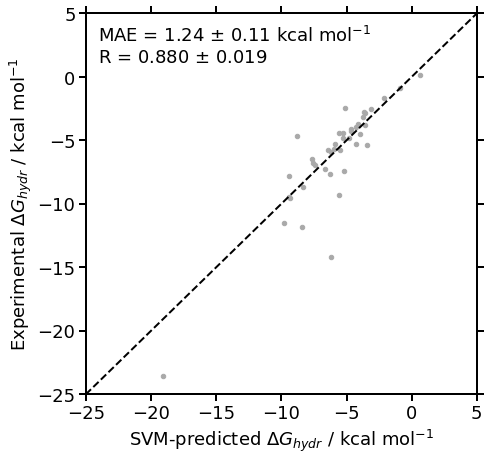

In [47]:
plot_scatter(calc=null_predicted_y,
             exp=null_test_y,
             title='SVM-predicted test set dGhydr',
             x_label='SVM-predicted $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             colour=colour1)

## Removing outlier

How does removing mobley_4587267 from the training and testing affect the result?

In [48]:
outlier = 'mobley_4587267'

Perform external testing with outlier removed from all testing sets.

In [49]:
# Remove outlier from all pre-defined DataFrames.
test_ID_o = test_ID.drop(outlier)
test_X_o = test_X.iloc[test_X.index != outlier, :]
test_y_o = test_y.iloc[test_y.index != outlier, :]
test_fep_o = test_fep.iloc[test_fep.index != outlier, :]
test_exp_o = test_exp.iloc[test_exp.index != outlier, :]

# Perform new offset predictions.
predict_per_fold_o = [model_predict(fold_num, test_X_o.to_numpy()) for fold_num in range(1, n_splits + 1)]
predicted_y_o = pd.DataFrame(data={'Average predicted dGoffset (kcal/mol)': [float(x) for x in np.average(predict_per_fold_o, axis=0)],
                                   'Standard deviation (kcal/mol)': np.std(predict_per_fold_o, axis=0)},
                             index=test_ID_o)

test_corr_o = pd.DataFrame(data={'FEP+ML dGoffset (kcal/mol)': [fep + offset for fep, offset in zip(test_fep_o.iloc[:,0], predicted_y_o.iloc[:,0])],
                               'uncertainty (kcal/mol)': [sum_error(x, y) for x, y in zip(predicted_y_o.iloc[:,1], test_fep_o.iloc[:,1])]},
                         index=test_ID_o)

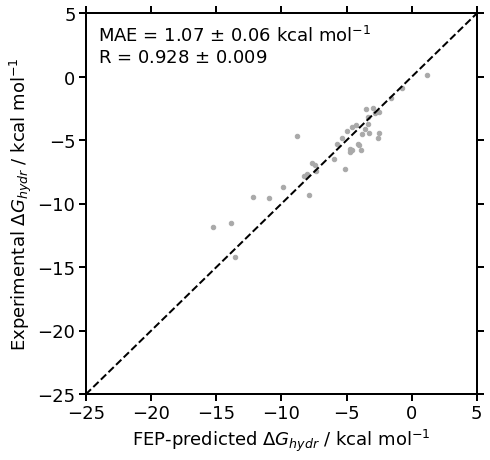

In [50]:
plot_scatter(calc=test_fep_o,
             exp=test_exp_o,
             title='Original test set hydraton free energy with removed outlier',
             x_label='FEP-predicted $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             colour=colour1)

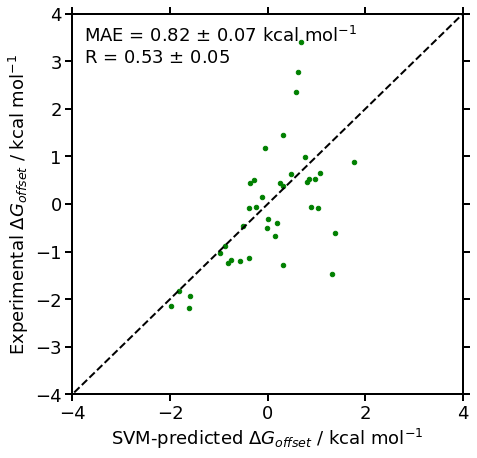

In [51]:
plot_scatter(calc=predicted_y_o,
             exp=test_y_o,
             title='SVM-predicted test set offsets with removed outlier',
             x_label='SVM-predicted $\Delta G_{offset}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta G_{offset}$ / kcal mol$^{-1}$',
             colour=colour2)

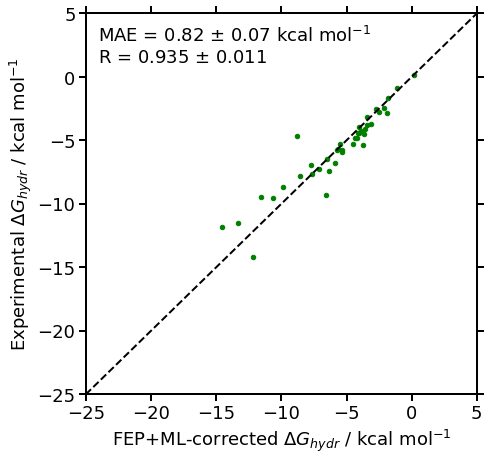

In [52]:
plot_scatter(calc=test_corr_o,
             exp=test_exp_o,
             title='FEP+ML corrected test set hydraton free energy with outlier removed',
             x_label='FEP+ML-corrected $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             colour=colour2)

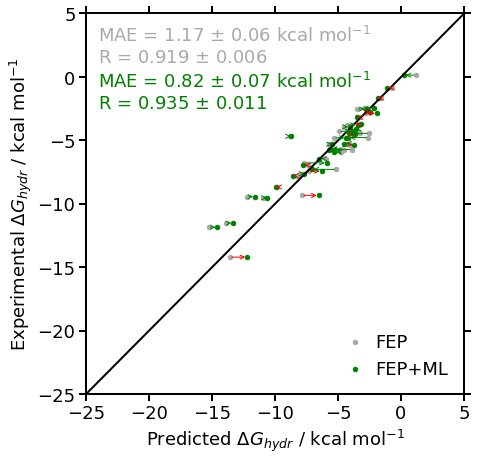

In [53]:
plot_scatter_with_arrows(calc=test_fep_o,
                         exp=test_exp_o,
                         offsets=predicted_y_o,
                         corr=test_corr_o)

## Recreating SAMPL4 Figure 1

In [54]:
sampl4_table3 = pd.read_csv(datasets_dr + 'SAMPL4_table_3.csv', dtype={'ID':str})
sampl4_table3 = sampl4_table3.set_index('ID')
sampl4_table3

,Avg. err.,error,RMS,error1,AUE,error2,tau,error3,R,error4,Err. slope,error5,Max. err.,error6
ID,,,,,,,,,,,,,,
004,0.13,0.13,1.40,0.12,1.10,0.10,0.73,0.06,0.93,0.02,0.99,0.07,4.98,0.47
005,-0.42,0.18,1.22,0.15,0.96,0.12,0.78,0.06,0.96,0.01,1.06,0.05,1.81,0.67
014,1.11,0.57,3.07,0.72,1.90,0.51,0.36,0.15,0.71,0.26,1.01,0.10,10.69,0.70
015,1.02,0.49,3.09,0.46,2.02,0.34,0.36,0.09,0.65,0.20,1.00,0.07,10.37,0.42
137,2.24,0.23,2.89,0.30,2.48,0.20,0.70,0.06,0.89,0.03,0.70,0.08,8.38,0.50
138,0.51,0.29,2.00,0.23,1.66,0.20,0.65,0.06,0.90,0.05,0.57,0.08,5.25,0.23
141,-0.07,0.28,1.46,0.18,1.07,0.11,0.74,0.07,0.93,0.02,0.72,0.08,6.02,0.46
145,-0.44,0.16,1.23,0.16,0.87,0.09,0.81,0.03,0.98,0.01,0.86,0.08,1.24,0.89
149,0.03,0.24,1.46,0.14,1.12,0.12,0.73,0.05,0.94,0.02,0.55,0.04,2.74,0.89


In [55]:
def new_sampl4_row(corr, exp, index):
    
    # Unpack data.
    xu = unumpy.uarray(corr.iloc[:,0], corr.iloc[:,1])
    yu = unumpy.uarray(exp.iloc[:,0], exp.iloc[:,1])
    
    avg_error = str(avg_err(xu, yu)).split('+/-')
    rms = str(rmse(xu, yu)).split('+/-')
    aue = str(calc_mae(xu, yu)).split('+/-')
    tau = kendall_tau(xu, yu)
    r = str(calc_pearson_r(xu, yu)).split('+/-')
    
    new_row = pd.DataFrame(data={'Avg. err.': float(avg_error[0]), 'error': float(avg_error[1]),
                                 'RMS': float(rms[0]), 'error1': float(rms[1]),
                                 'AUE': float(aue[0]), 'error2': float(aue[1]),
                                 'tau': tau, 'error3': 0.0,
                                 'R': float(r[0]), 'error4': float(r[1]),
                                 'Err. slope': 0.0, 'error5': 0.0,
                                 'Max. err.': 0.0, 'error6': 0.0},
                           index=[index])
    
    return new_row

Append FEP+ML results to the original SAMPL4 Table 3.

In [56]:
fep_ml_df = new_sampl4_row(corr=test_corr, exp=test_exp, index='FEP+ML')
fep_ml_df.to_csv('fep_ml_df.csv', index=True, index_label='Submission ID')
svm_df = new_sampl4_row(corr=null_predicted_y, exp=test_exp, index='ML')
# dnn_predicted_y = pd.read_csv('../dGhydr_DNN/output_null/null_predicted_dGhydr_DNN.csv', index_col='ID')
# dnn_df = new_sampl4_row(corr=dnn_predicted_y, exp=test_exp, index='ML')

In [57]:
def plot_sampl4_bar_mae(*args):
    
    # Setup figure.
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for axis in ['top','bottom','left','right']: ax.spines[axis].set_linewidth(linewidth)  # Frame line width.
    ax.tick_params(axis='both', which='major', labelsize=fontsize)  # Axis number font size.
    
    # Read in original SAMPL4 Table 3 and retain index column values as strings.
    sampl4_df = pd.read_csv(datasets_dr + 'SAMPL4_table_3.csv', dtype={'ID':str})
    sampl4_df = sampl4_df.set_index('ID')
    
    # Determine whether to append new data to existing DataFrame.
    figure_num = 1
    for arg in args:
        sampl4_df = sampl4_df.append(arg, sort=False)
        figure_num += 1
    
    # Locate metric and respective uncertainties columns.
    metric_df = sampl4_df.iloc[:, [4,5]]
    # Sort DataFrame accroding to metric column.
    metric_df = metric_df.sort_values(by=metric_df.columns[0])

    # Only plot the two twenty submissions.
    metric_df = metric_df.head(20)

    # Change the index '004' to 'FEP'
    as_list = metric_df.index.tolist()
    idx = as_list.index('004')
    as_list[idx] = 'FEP'
    metric_df.index = as_list
    
    # Locate FEP, ML and FEP+ML submissions where applicable.
    metric_fep = metric_df.loc['FEP',metric_df.columns[0]]
    try: metric_ml = metric_df.loc['ML']
    except KeyError: pass
    try: metric_fep_ml = metric_df.loc['FEP+ML']
    except KeyError: pass

    # Plot bar graphs of all subissions, FEP, ML and FEP+ML where applicable.
    ax.bar(metric_df.index, metric_df.iloc[:,0], yerr=metric_df.iloc[:,1],color=colour3, label='Other submissions')
    ax.bar('FEP', metric_fep, color=colour1, label='FEP')
    try: ax.bar('ML', metric_ml, color=colour4, label='ML')
    except NameError: pass
    try: ax.bar('FEP+ML', metric_fep_ml, color=colour2, label='FEP+ML')
    except NameError: pass

    # Axes formatting.
    ax.set_ylabel('Mean absolute error / kcal mol{}'.format('$^{-1}$'), fontsize=fontsize)
    ax.set_xlabel('Submission ID', labelpad=8, fontsize=fontsize)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize) 
        tick.label.set_rotation('vertical')
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(reversed(handles), reversed(labels), bbox_to_anchor=(1.5, 0.55), ncol=1)

    plt.tight_layout()
    plt.savefig(figures_dr + model_type + '_' + str(figure_num) + '_SAMPL4_panel_mae.png', dpi=dpi)

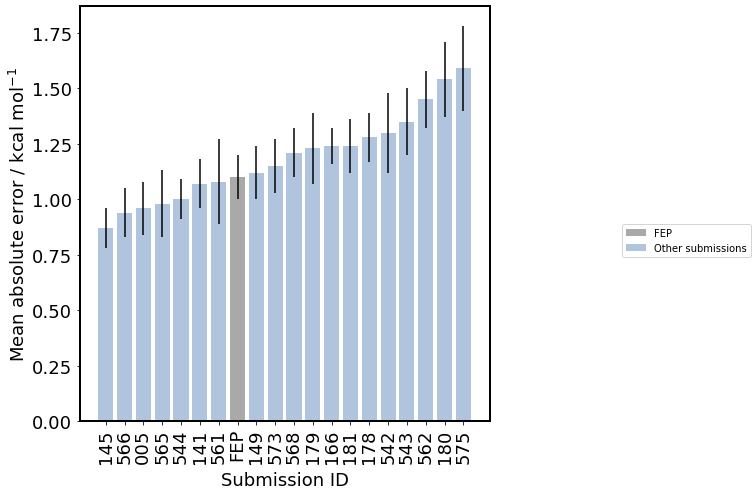

In [58]:
plot_sampl4_bar_mae()

In [59]:
def plot_sampl4_bar_r(*args):
    
    # Setup figure.
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for axis in ['top','bottom','left','right']: ax.spines[axis].set_linewidth(linewidth)  # Frame line width.
    ax.tick_params(axis='both', which='major', labelsize=fontsize)  # Axis number font size.
    
    # Read in original SAMPL4 Table 3 and retain index column values as strings.
    sampl4_df = pd.read_csv(datasets_dr + 'SAMPL4_table_3.csv', dtype={'ID':str})
    sampl4_df = sampl4_df.set_index('ID')
    
    # Determine whether to append new data to existing DataFrame.
    figure_num = 1
    for arg in args:
        sampl4_df = sampl4_df.append(arg, sort=False)
        figure_num += 1
    
    # Locate metric and respective uncertainties columns.
    metric_df = sampl4_df.iloc[:, [8,9]]
    # Sort DataFrame accroding to metric column.
    metric_df = metric_df.sort_values(by=metric_df.columns[0])
    # Reverse DataFrame for Pearson R.
    metric_df = metric_df.iloc[::-1]

    # Only plot the two twenty submissions.
    metric_df = metric_df.head(20)

    # Change the index '004' to 'FEP'
    as_list = metric_df.index.tolist()
    idx = as_list.index('004')
    as_list[idx] = 'FEP'
    metric_df.index = as_list
    
    # Locate FEP, ML and FEP+ML submissions where applicable.
    metric_fep = metric_df.loc['FEP',metric_df.columns[0]]
    try: metric_ml = metric_df.loc['ML']
    except KeyError: pass
    try: metric_fep_ml = metric_df.loc['FEP+ML']
    except KeyError: pass

    # Plot bar graphs of all subissions, FEP, ML and FEP+ML where applicable.
    ax.bar(metric_df.index, metric_df.iloc[:,0], yerr=metric_df.iloc[:,1],color=colour3, label='Other submissions')
    ax.bar('FEP', metric_fep, color=colour1, label='FEP')
    try: ax.bar('ML', metric_ml, color=colour4, label='ML')
    except NameError: pass
    try: ax.bar('FEP+ML', metric_fep_ml, color=colour2, label='FEP+ML')
    except NameError: pass

    # Axes formatting.
    ax.set_ylabel('Pearson R coefficient'.format('$^{-1}$'), fontsize=fontsize)
    ax.set_xlabel('Submission ID', labelpad=8, fontsize=fontsize)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize) 
        tick.label.set_rotation('vertical')
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(reversed(handles), reversed(labels), bbox_to_anchor=(1.5, 0.55), ncol=1)

    plt.tight_layout()
    plt.savefig(figures_dr + model_type + '_' + str(figure_num) + '_SAMPL4_panel_r.png', dpi=dpi)

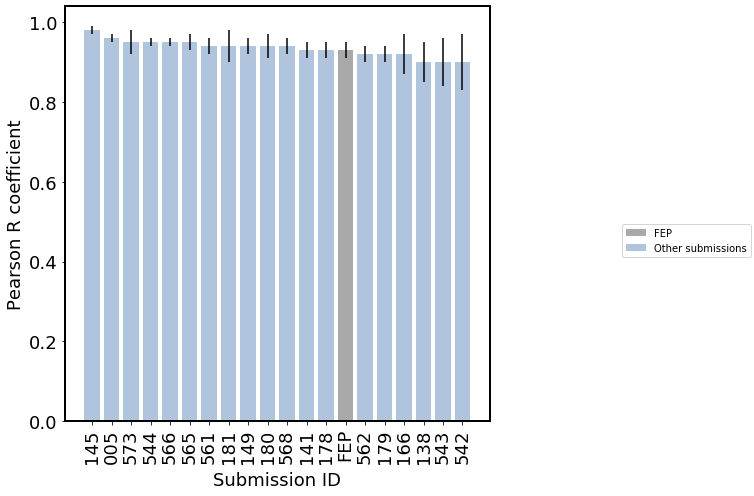

In [60]:
plot_sampl4_bar_r()

In [61]:
def plot_sampl4_bar(*args):
    
    # Setup figure.
    fig, ax = plt.subplots(1, 2, figsize=[12, 6])
    for i in [0, 1]:
        for axis in ['top','bottom','left','right']: ax[i].spines[axis].set_linewidth(linewidth)  # Frame line width.
        ax[i].tick_params(axis='both', which='major', labelsize=fontsize)  # Axis number font size.
    
    # Read in original SAMPL4 Table 3 and retain index column values as strings.
    sampl4_df = pd.read_csv(datasets_dr + 'SAMPL4_table_3.csv', dtype={'ID':str})
    sampl4_df = sampl4_df.set_index('ID')
    
    # Determine whether to append new data to existing DataFrame.
    figure_num = 1
    for arg in args:
        sampl4_df = sampl4_df.append(arg, sort=False)
        figure_num += 1
    
    # Dictionary of metrics to plot as keys and respective column index locations in SAMPL4_df as values.
    metric_dict = {'MAE': 4, 'Pearson R': 8}
    
    # Loop through each metric and plot ax.
    for i, metric in zip([0, 1], metric_dict):
        # Locate metric and respective uncertainties columns.
        metric_df = sampl4_df.iloc[:, [metric_dict[metric], metric_dict[metric] + 1]]
        # Sort DataFrame accroding to metric column.
        metric_df = metric_df.sort_values(by=metric_df.columns[0])
        
        # Reverse DataFrame if plotting Pearson R only.
        if metric == 'MAE': pass
        elif metric == 'Pearson R': metric_df = metric_df.iloc[::-1]

        # # Uncomment if avg. err. was added to metric_dict.
        # if metric == 'MAE':
        #     metric_df = metric_df.iloc[metric_df.abs().argsort()]
        # elif metric == 'Pearson R':
        #     metric_df = metric_df.iloc[metric_df.abs().argsort()].iloc[::-1]
        
        # Only plot the two twenty submissions.
        metric_df = metric_df.head(20)
        
        # Locate FEP, ML and FEP+ML submissions where applicable.
        metric_fep = metric_df.loc['004',metric_df.columns[0]]
        try: metric_ml = metric_df.loc['ML']
        except KeyError: pass
        try: metric_fep_ml = metric_df.loc['FEP+ML']
        except KeyError: pass
        
        # Plot bar graphs of all subissions, FEP, ML and FEP+ML where applicable.
        ax[i].bar(metric_df.index, metric_df.iloc[:,0], yerr=metric_df.iloc[:,1],color=colour3, label='Other submissions')
        ax[i].bar('004', metric_fep, color=colour1, label='FEP')
        try: ax[i].bar('ML', metric_ml, color=colour4, label='ML')
        except NameError: pass
        try: ax[i].bar('FEP+ML', metric_fep_ml, color=colour2, label='FEP+ML')
        except NameError: pass
        
        # Axes formatting.
        if metric == 'MAE':
            ax[i].set_ylabel('Mean absolute error / kcal mol{}'.format('$^{-1}$'), fontsize=fontsize)
        else:
            ax[i].set_ylabel('Pearson R / kcal mol{}'.format('$^{-1}$'), fontsize=fontsize)
        ax[i].set_xlabel('Submission ID', labelpad=8, fontsize=fontsize)
        for tick in ax[i].xaxis.get_major_ticks():
            tick.label.set_fontsize(fontsize) 
            tick.label.set_rotation('vertical')
        handles, labels = ax[i].get_legend_handles_labels()
        fig.legend(reversed(handles), reversed(labels), bbox_to_anchor=(1.15, 0.55), ncol=1)

    plt.tight_layout()
    plt.savefig(figures_dr + model_type + '_' + str(figure_num) + '_SAMPL4_panel.png', dpi=dpi)

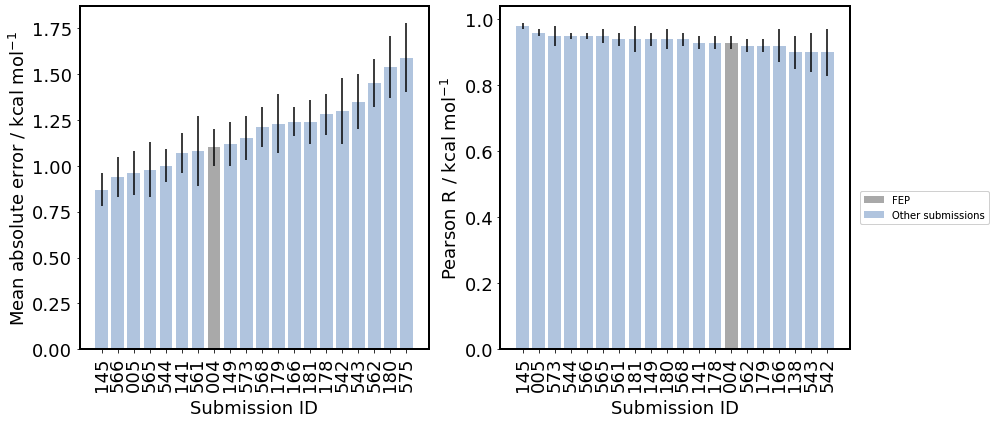

In [62]:
plot_sampl4_bar()

SVM control

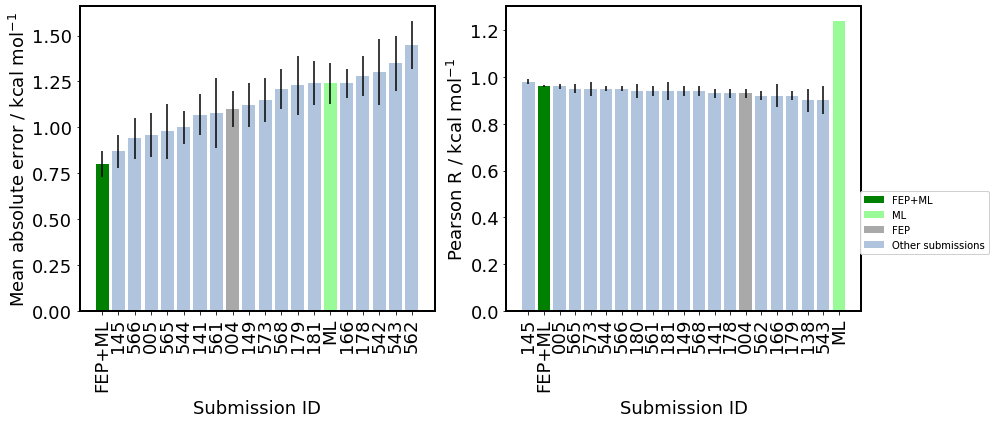

In [63]:
plot_sampl4_bar(fep_ml_df, svm_df)